In [5]:
import os
import re
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


def image_list(image_dir):
    """Builds a list of training images from the file system.
      Analyzes the sub folders in the image directory, and returns a data structure
      describing the lists of images for each label and their paths.
      
      Args:
        image_dir: String path to a folder containing subfolders of images.

      Returns:
        A dictionary containing an entry for each label subfolder
      """
    # Checks if the directory name even exists!
    if not gfile.Exists(image_dir):
        print("Image directory '" + image_dir + "' not found.")
        return None

    result = {}
    sub_dirs = [x[0] for x in gfile.Walk(image_dir)] # This will create a list of sub directories i.e Kickflip, ollie
    final_result = []

    is_root_dir = True
    for sub_dir in sub_dirs:
        if is_root_dir:
            is_root_dir = False # Because the first element is the root directory, we skip it to go into the sub directories
            continue
        extensions = ['jpg', 'JPG'] # Image extension
        file_list = [] # File path list of all the images in the directory
        dir_name = os.path.basename(sub_dir) # This will make the dir_name to be 'Kickflip' or 'Ollie'
        if dir_name == image_dir:
            continue
        print("Looking for images in '" + dir_name + "'")
        for extension in extensions:
            file_glob = os.path.join(image_dir, dir_name, '*.' + extension) # Making a file path for all photos with given extension
            file_list.extend(gfile.Glob(file_glob)) # This will add the 'file_glob' string to file_list
        if not file_list:
            print('No files have been found')
            continue
        if len(file_list) < 20: # This will check the length of the file_list
            print('There is less than 20 photos in this directory! There may not be enough pictures!')

        label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower()) #This makes the label name for each spacific Image

        result[label_name] = file_list

    for value in result.values():
        final_result.extend(value)
    return final_result

"""
Credit to Kernix blog
"""

def create_graph():
    """
    create_graph loads the inception model to memory, should be called before
    calling extraction. This is called in the extraction function.
    """
    model_dir = 'imagenet'
    with gfile.FastGFile(os.path.join(model_dir,
                    'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

def extraction(final_result):
    """
    extract_features computed the inception bottleneck feature for a list of images

    image_paths: array of image path
    return: 2-d array in the shape of (len(image_paths), 2048)
    """

    nb_features = 2048
    features = np.empty((len(final_result),nb_features))
    labels = []

    create_graph()

    with tf.Session() as sess:

        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')

        for ind, image in enumerate(final_result):
            if (ind%100 == 0):
                print('Processing %s...' % (image))
            if not gfile.Exists(image):
                tf.logging.fatal('File does not exist %s', image)

            image_data = gfile.FastGFile(image, 'rb').read()

            predictions = sess.run(next_to_last_tensor,
                            {'DecodeJpeg/contents:0': image_data})

            features[ind,:] = np.squeeze(predictions)

            labels.append(re.split('_\d+',image.split('/')[1])[0])


    if len(labels) > 1:
        model_output_path = 'pickle_files/'
        with open(model_output_path + 'features.pkl','wb') as f:
            pickle.dump(features, f)

        with open(model_output_path + 'labels.pkl', 'wb') as l:
            pickle.dump(labels, l)
    else:
        return features


In [3]:
final_list = image_list('train_photos/')

Looking for images in 'Kickflip'
Looking for images in 'Ollie'


In [4]:
extraction(final_list)

Processing train_photos/Kickflip/IMG_1816.jpg...
Processing train_photos/Kickflip/IMG_1918.jpg...
Processing train_photos/Kickflip/IMG_2117.jpg...
Processing train_photos/Kickflip/IMG_9145.jpg...
Processing train_photos/Kickflip/IMG_9247.jpg...
Processing train_photos/Kickflip/IMG_9444.jpg...
Processing train_photos/Ollie/IMG_1798.jpg...
Processing train_photos/Ollie/IMG_2045.jpg...
Processing train_photos/Ollie/IMG_9066.jpg...
Processing train_photos/Ollie/IMG_9316.jpg...


FileNotFoundError: [Errno 2] No such file or directory: '../pickle_files/features.pkl'

In [47]:
gfile.Exists('Capstone_photo/kickflip_test/IMG_8983.JPG')

True

In [17]:
import os
import pickle

import sklearn
from sklearn import grid_search
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.externals import joblib

def train_svm_classifer(features, labels):
    """
    train_svm_classifer will train a SVM, saved the trained and SVM model and
    report the classification performance

    features: array of input features
    labels: array of labels associated with the input features
    model_output_path: path for storing the trained svm model
    """
    # Our test set will be 20% of the whole data set.
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

    param = [{"kernel": ["linear"],
                 "C": [1, 10, 100, 1000]},
             {"kernel": ["rbf"],
                 "C": [1, 10, 100, 1000],
                 "gamma": [1e-2, 1e-3, 1e-4, 1e-5]}]

    # Probability is requested as True
    svm = SVC(probability=True)

    # 10-fold cross validation, use 4 thread as each fold and each parameter set can be train in parallel
    SVM = grid_search.GridSearchCV(svm, param,
            cv=10, n_jobs=4, verbose=3)

    # This will save the trained model in a pickle file to be used later
    model = SVM.fit(X_train, y_train)
    model_path = '../pickle_files/svm_model.pkl'
    with open(model_path,'wb') as f:
        pickle.dump(model,f)
    
    y_predict = model.predict(X_test)


    print("\nThe Best Parameters:")
    print(SVM.best_params_)

    print("\nClassification report:")
    print(classification_report(y_test, y_predict))

if __name__ == '__main__':
    with open('../pickle_files/features.pkl', 'rb') as f:
        features = pickle.load(f)
    with open('../pickle_files/labels.pkl', 'rb') as l:
        labels = pickle.load(l)
    train_svm_classifer(features, labels)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/nathancho/anaconda/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10fa648a0, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/nathancho/anaconda/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/nathancho/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/natha.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10fa648a0, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/nathancho/anaconda/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/nathancho/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/natha.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'import os\nimport pickle\n\nimport sklearn\nfrom skl...oad(l)\n    train_svm_classifer(features, labels)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 7, 7, 21, 55, 50, 551791, tzinfo=datetime.timezone.utc), 'msg_id': '6A282B2756C34BA4817DA49F4C759313', 'msg_type': 'execute_request', 'session': 'B9233E0A5C8942358F9342406327C878', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6A282B2756C34BA4817DA49F4C759313', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'B9233E0A5C8942358F9342406327C878']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'import os\nimport pickle\n\nimport sklearn\nfrom skl...oad(l)\n    train_svm_classifer(features, labels)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 7, 7, 21, 55, 50, 551791, tzinfo=datetime.timezone.utc), 'msg_id': '6A282B2756C34BA4817DA49F4C759313', 'msg_type': 'execute_request', 'session': 'B9233E0A5C8942358F9342406327C878', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6A282B2756C34BA4817DA49F4C759313', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'B9233E0A5C8942358F9342406327C878'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'import os\nimport pickle\n\nimport sklearn\nfrom skl...oad(l)\n    train_svm_classifer(features, labels)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 7, 7, 21, 55, 50, 551791, tzinfo=datetime.timezone.utc), 'msg_id': '6A282B2756C34BA4817DA49F4C759313', 'msg_type': 'execute_request', 'session': 'B9233E0A5C8942358F9342406327C878', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6A282B2756C34BA4817DA49F4C759313', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='import os\nimport pickle\n\nimport sklearn\nfrom skl...oad(l)\n    train_svm_classifer(features, labels)\n', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'import os\nimport pickle\n\nimport sklearn\nfrom skl...oad(l)\n    train_svm_classifer(features, labels)\n'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('import os\nimport pickle\n\nimport sklearn\nfrom skl...oad(l)\n    train_svm_classifer(features, labels)\n',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('import os\nimport pickle\n\nimport sklearn\nfrom skl...oad(l)\n    train_svm_classifer(features, labels)\n',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='import os\nimport pickle\n\nimport sklearn\nfrom skl...oad(l)\n    train_svm_classifer(features, labels)\n', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Import object>, <_ast.Import object>, <_ast.Import object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.FunctionDef object>, <_ast.If object>], cell_name='<ipython-input-17-017b3064d59f>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 13ed7bc88, execution_..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x13ed35030, file "<ipython-input-17-017b3064d59f>", line 51>
        result = <ExecutionResult object at 13ed7bc88, execution_..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x13ed35030, file "<ipython-input-17-017b3064d59f>", line 51>, result=<ExecutionResult object at 13ed7bc88, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x13ed35030, file "<ipython-input-17-017b3064d59f>", line 51>
        self.user_global_ns = {'In': ['', 'import os\nimport re\nimport tensorflow as tf\nimpo...dump(labels, l)\n    else:\n        return features', 'extraction(final_list)', "final_list = image_list('train_photos/')", "final_list = image_list('../train_photos/')", 'extraction(final_list)', 'import os\nimport re\nimport tensorflow as tf\nimpo...dump(labels, l)\n    else:\n        return features', 'extraction(final_list)', 'import os\nimport re\nimport tensorflow as tf\nimpo...dump(labels, l)\n    else:\n        return features', 'extraction(final_list)', 'import os\nimport pickle\n\nimport sklearn\nfrom skl....load(l)\n    train_svm_classifer(features,labels)', 'import os\nimport pickle\n\nimport sklearn\nfrom skl....load(l)\n    train_svm_classifer(features,labels)', 'import os\nimport pickle\n\nimport sklearn\nfrom skl...load(l)\n    train_svm_classifer(features, labels)', "final_list = image_list('../train_photos/')\nlen(final_list)", "final_list = image_list('../train_photos/')", 'import os\nimport pickle\n\nimport sklearn\nfrom skl...load(l)\n    train_svm_classifer(features, labels)', 'import os\nimport pickle\n\nimport sklearn\nfrom skl...load(l)\n    train_svm_classifer(features, labels)', 'import os\nimport pickle\n\nimport sklearn\nfrom skl...load(l)\n    train_svm_classifer(features, labels)'], 'Out': {13: 962}, 'SVC': <class 'sklearn.svm.classes.SVC'>, '_': 962, '_13': 962, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': '\nCredit to Kernix blog\n', ...}
        self.user_ns = {'In': ['', 'import os\nimport re\nimport tensorflow as tf\nimpo...dump(labels, l)\n    else:\n        return features', 'extraction(final_list)', "final_list = image_list('train_photos/')", "final_list = image_list('../train_photos/')", 'extraction(final_list)', 'import os\nimport re\nimport tensorflow as tf\nimpo...dump(labels, l)\n    else:\n        return features', 'extraction(final_list)', 'import os\nimport re\nimport tensorflow as tf\nimpo...dump(labels, l)\n    else:\n        return features', 'extraction(final_list)', 'import os\nimport pickle\n\nimport sklearn\nfrom skl....load(l)\n    train_svm_classifer(features,labels)', 'import os\nimport pickle\n\nimport sklearn\nfrom skl....load(l)\n    train_svm_classifer(features,labels)', 'import os\nimport pickle\n\nimport sklearn\nfrom skl...load(l)\n    train_svm_classifer(features, labels)', "final_list = image_list('../train_photos/')\nlen(final_list)", "final_list = image_list('../train_photos/')", 'import os\nimport pickle\n\nimport sklearn\nfrom skl...load(l)\n    train_svm_classifer(features, labels)', 'import os\nimport pickle\n\nimport sklearn\nfrom skl...load(l)\n    train_svm_classifer(features, labels)', 'import os\nimport pickle\n\nimport sklearn\nfrom skl...load(l)\n    train_svm_classifer(features, labels)'], 'Out': {13: 962}, 'SVC': <class 'sklearn.svm.classes.SVC'>, '_': 962, '_13': 962, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': '\nCredit to Kernix blog\n', ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/nathancho/Galvanize/Skateboard_Trick_Identifier/jupyter_notebook/<ipython-input-17-017b3064d59f> in <module>()
     51 if __name__ == '__main__':
     52     with open('../pickle_files/features.pkl', 'rb') as f:
     53         features = pickle.load(f)
     54     with open('../pickle_files/labels.pkl', 'rb') as l:
     55         labels = pickle.load(l)
---> 56     train_svm_classifer(features, labels)
     57 
     58 
     59 
     60 

...........................................................................
/Users/nathancho/Galvanize/Skateboard_Trick_Identifier/jupyter_notebook/<ipython-input-17-017b3064d59f> in train_svm_classifer(features=array([[ 0.68875247,  0.30240571,  0.14457312, ....  0.48904368,
         0.32117608,  1.08670139]]), labels=['train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', ...])
     32     # 10-fold cross validation, use 4 thread as each fold and each parameter set can be train in parallel
     33     SVM = grid_search.GridSearchCV(svm, param,
     34             cv=10, n_jobs=4, verbose=3)
     35 
     36     # This will save the trained model in a pickle file to be used later
---> 37     model = SVM.fit(X_train, y_train)
     38     model_path = '../pickle_files/svm_model.pkl'
     39     with open(model_path,'wb') as f:
     40         pickle.dump(model,f)
     41     

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=10, error_score='raise',
       ...='2*n_jobs', refit=True, scoring=None, verbose=3), X=array([[ 1.49620712,  0.26490271,  0.04818439, ....  0.54238927,
         0.01719912,  1.63525677]]), y=['train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', ...])
    824         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    825             Target relative to X for classification or regression;
    826             None for unsupervised learning.
    827 
    828         """
--> 829         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...'2*n_jobs', refit=True, scoring=None, verbose=3)>
        X = array([[ 1.49620712,  0.26490271,  0.04818439, ....  0.54238927,
         0.01719912,  1.63525677]])
        y = ['train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', ...]
        self.param_grid = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 1e-05], 'kernel': ['rbf']}]
    830 
    831 
    832 class RandomizedSearchCV(BaseSearchCV):
    833     """Randomized search on hyper parameters.

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=10, error_score='raise',
       ...='2*n_jobs', refit=True, scoring=None, verbose=3), X=array([[ 1.49620712,  0.26490271,  0.04818439, ....  0.54238927,
         0.01719912,  1.63525677]]), y=['train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', ...], parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    568         )(
    569             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    570                                     train, test, self.verbose, parameters,
    571                                     self.fit_params, return_parameters=True,
    572                                     error_score=self.error_score)
--> 573                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    574                 for train, test in cv)
    575 
    576         # Out is a list of triplet: score, estimator, n_test_samples
    577         n_fits = len(out)

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Jul  7 14:55:50 2017
PID: 32161               Python 3.6.1: /Users/nathancho/anaconda/bin/python
...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (SVC(C=1, cache_size=200, class_weight=None, coef...None, shrinking=True,
  tol=0.001, verbose=False), memmap([[ 1.49620712,  0.26490271,  0.04818439, ... 0.54238927,
          0.01719912,  1.63525677]]), ['train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', ...], <function _passthrough_scorer>, array([ 77,  78,  79,  80,  81,  82,  83,  84,  ..., 761, 762, 763, 764, 765,
       766, 767, 768]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76]), 3, {'C': 1, 'kernel': 'linear'}, {}), {'error_score': 'raise', 'return_parameters': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (SVC(C=1, cache_size=200, class_weight=None, coef...None, shrinking=True,
  tol=0.001, verbose=False), memmap([[ 1.49620712,  0.26490271,  0.04818439, ... 0.54238927,
          0.01719912,  1.63525677]]), ['train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', ...], <function _passthrough_scorer>, array([ 77,  78,  79,  80,  81,  82,  83,  84,  ..., 761, 762, 763, 764, 765,
       766, 767, 768]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76]), 3, {'C': 1, 'kernel': 'linear'}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=SVC(C=1, cache_size=200, class_weight=None, coef...None, shrinking=True,
  tol=0.001, verbose=False), X=memmap([[ 1.49620712,  0.26490271,  0.04818439, ... 0.54238927,
          0.01719912,  1.63525677]]), y=['train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', ...], scorer=<function _passthrough_scorer>, train=array([ 77,  78,  79,  80,  81,  82,  83,  84,  ..., 761, 762, 763, 764, 765,
       766, 767, 768]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76]), verbose=3, parameters={'C': 1, 'kernel': 'linear'}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1660 
   1661     try:
   1662         if y_train is None:
   1663             estimator.fit(X_train, **fit_params)
   1664         else:
-> 1665             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseLibSVM.fit of SVC(C=1, cache_s...one, shrinking=True,
  tol=0.001, verbose=False)>
        X_train = memmap([[ 1.87903595,  0.25785396,  0.07175495, ... 0.54238927,
          0.01719912,  1.63525677]])
        y_train = ['train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', 'train_photos', ...]
        fit_params = {}
   1666 
   1667     except Exception as e:
   1668         if error_score == 'raise':
   1669             raise

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py in fit(self=SVC(C=1, cache_size=200, class_weight=None, coef...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[ 1.87903595,  0.25785396,  0.07175495, ....  0.54238927,
         0.01719912,  1.63525677]]), y=array(['train_photos', 'train_photos', 'train_ph...ain_photos', 'train_photos'],
      dtype='<U12'), sample_weight=None)
    147         if sparse and self.kernel == "precomputed":
    148             raise TypeError("Sparse precomputed kernels are not supported.")
    149         self._sparse = sparse and not callable(self.kernel)
    150 
    151         X, y = check_X_y(X, y, dtype=np.float64, order='C', accept_sparse='csr')
--> 152         y = self._validate_targets(y)
        y = array(['train_photos', 'train_photos', 'train_ph...ain_photos', 'train_photos'],
      dtype='<U12')
        self._validate_targets = <bound method BaseSVC._validate_targets of SVC(C...one, shrinking=True,
  tol=0.001, verbose=False)>
    153 
    154         sample_weight = np.asarray([]
    155                                    if sample_weight is None
    156                                    else sample_weight, dtype=np.float64)

...........................................................................
/Users/nathancho/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py in _validate_targets(self=SVC(C=1, cache_size=200, class_weight=None, coef...None, shrinking=True,
  tol=0.001, verbose=False), y=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]))
    521         cls, y = np.unique(y_, return_inverse=True)
    522         self.class_weight_ = compute_class_weight(self.class_weight, cls, y_)
    523         if len(cls) < 2:
    524             raise ValueError(
    525                 "The number of classes has to be greater than one; got %d"
--> 526                 % len(cls))
        cls = array(['train_photos'],
      dtype='<U12')
    527 
    528         self.classes_ = cls
    529 
    530         return np.asarray(y, dtype=np.float64, order='C')

ValueError: The number of classes has to be greater than one; got 1
___________________________________________________________________________

Please input a file path for the image: Capstone_photo/kickflip_test/IMG_8990.JPG
Processing Capstone_photo/kickflip_test/IMG_8990.JPG...
Your prediction...

['Kickflip'] [[ 0.99851803  0.00148197]]


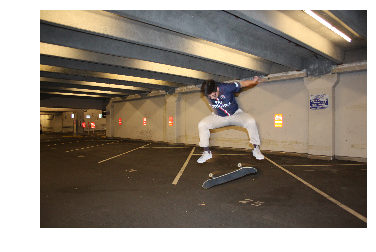

In [18]:
def predict_one(image_path):
    #image = image_list(image_path)
    feature_vector = extraction([image_path])
    model_path = 'pickle_files/svm_model.pkl'
    with open(model_path, 'rb') as s:
        model = pickle.load(s)

    prediction_class = model.predict(feature_vector)
    prediction = model.predict_proba(feature_vector)

    print('\nYour prediction...')
    print(prediction_class, prediction)
    image_show(image_path)

# Capstone_photo/random_test_pictures/test_ollie_photo_two.jpg "Negative prediction"
# Capstone_photo/ollie_test/IMG_8976.JPG "True Positive"
# Capstone_photo/ollie_test/IMG_8995.JPG 
# Capstone_photo/random_test_pictures/Kickflip-test_photo.jpg "True Positive" internet photo
# Capstone_photo/random_test_pictures/kickflip-test_2.jpg "True Positive" internet kickflip photo
# Capstone_photo/random_test_pictures/how-to-ollie-4.jpg "False classification"
# Capstone_photo/random_test_pictures/ollie_test_1.jpg
# Capstone_photo/kickflip_test/IMG_8990.JPG "True Classification"

if __name__ == '__main__':
    image_path = input('Please input a file path for the image: ')
    predict_one(str(image_path))


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [16]:
def image_show(filepath):
    img = mpimg.imread(filepath)
    plt.imshow(img)
    plt.axis('off')

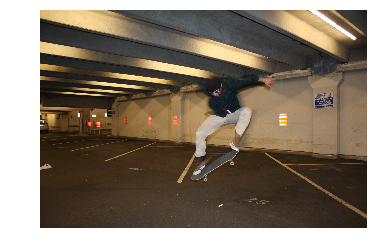

In [17]:
image_show('Capstone_photo/ollie_test/IMG_8969.JPG')

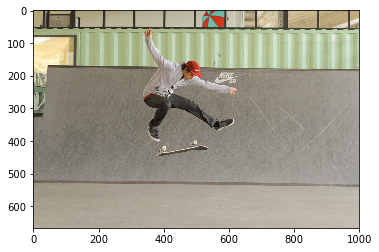

In [14]:
image_show('Capstone_photo/random_test_pictures/Kickflip-test_photo.jpg')